In [26]:
import string
import numpy as np
import pandas as pd

In [2]:
notesdf = pd.read_excel('P:/ORD_Singh_201911038D/Justin/InpatNote.xls')
print("DataFrame columns: ", ','.join([x for x in notesdf.columns]))
print(len(['_'.join(x) for x in zip(notesdf.StudyID.astype(str), notesdf.TIUDocumentSID.astype(str))]))
print(len(np.unique(['_'.join(x) for x in zip(notesdf.StudyID.astype(str), notesdf.TIUDocumentSID.astype(str))])))

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
DataFrame columns:  StudyID,ReportText,TIUStandardTitle,TIUDocumentDefinition,TIUDocumentSID
2730
2730


In [3]:
notesdf.ReportText = notesdf.ReportText.str.replace("\s+", " ", regex=True).str.replace("'", "").str.replace('"', '')

In [5]:
from sklearn.preprocessing import MinMaxScaler

#Load the old data set for which we have labels
structdf = pd.read_csv("paarthwork/input/input.csv")
structdf = structdf.drop('smk_flags_man', axis=1)
structdf = structdf.drop('smk_flags_db', axis=1)
structdf = structdf[structdf.mod_label != 'INVALID']
print(f'Columns in df:\n{", ".join([x for x in structdf.columns])}')
label_column = 'mod_label'
feature_columns = list(structdf.columns)
feature_columns.remove(label_column)
feature_columns_cont = [
    'ed_inp_delta'
    ,'ed_duration'
    ,'elix_score'
    ,'age_val'
]
feature_columns_cat = [
    'img_flags'
    ,'con_flags'
]

structdf['ed_inp_delta'] = MinMaxScaler().fit_transform(structdf['ed_inp_delta'].values.reshape(-1,1))
structdf['ed_duration'] = MinMaxScaler().fit_transform(structdf['ed_duration'].values.reshape(-1,1))
structdf['elix_score'] = MinMaxScaler().fit_transform(structdf['elix_score'].values.reshape(-1,1))
structdf['age_val'] = MinMaxScaler().fit_transform(structdf['age_val'].values.reshape(-1,1))

Columns in df:
study_ids, ed_duration, ed_inp_delta, age_val, img_flags, con_flags, elix_score, mod_label


In [13]:
study_notes_flat = {x:' '.join(notesdf[notesdf.StudyID == x].ReportText.str.lower().values) for x in structdf.study_ids}

In [ ]:
for key,values in study_notes_flat.copy().items():
    if values == '':
        print(key)
        del study_notes_flat[key]

In [46]:
retained_notes = pd.DataFrame.from_dict(study_notes_flat, orient='index')
retained_notes = retained_notes.reset_index()
retained_notes.columns = ['StudyID', 'TEXT']
retained_notes.shape

(192, 2)

In [45]:
retaineddf = structdf[structdf.study_ids.isin(retained_notes.StudyID)]
retaineddf.shape

(192, 8)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [27]:
def custom_tokenizer(text):
    punctuation_numbers = string.punctuation + '0123456789'
    translation = str.maketrans(dict.fromkeys(punctuation_numbers, " "))
    text = text.translate(translation)
    tokens = text.split()
    return tokens
    
vectorizer = CountVectorizer(max_features=3000, tokenizer = custom_tokenizer)
X = vectorizer.fit_transform(retained_notes.TEXT.values)
print(' | '.join(np.asarray(vectorizer.get_feature_names())[np.argsort(np.sum(X.toarray(), axis=0))[-100:]][::-1]))
print(X.toarray().shape)

to | no | for | and | the | of | active | mg | a | by | patient | or | take | mouth | in | pain | with | one | tab | day | is | tablet | as | at | medications | every | he | pt | you | on | blood | cm | not | x | time | was | have | has | this | icd | days | yes | your | non | s | normal | l | needed | if | last | c | va | date | use | daily | status | discharge | twice | other | care | assessment | pressure | ct | any | history | times | that | his | cap | are | n | dizziness | sig | outpatient | ml | medication | denies | emergency | up | pulse | home | o | from | provider | f | d | do | headache | dl | left | skin | refills | chest | symptoms | heart | hcl | be | right | given | i
(192, 3000)


In [29]:
vectorizer = CountVectorizer(max_features=3000, tokenizer = custom_tokenizer, stop_words='english', min_df = 10)
X = vectorizer.fit_transform(retained_notes.TEXT.values)
print(' | '.join(np.asarray(vectorizer.get_feature_names())[np.argsort(np.sum(X.toarray(), axis=0))[-100:]][::-1]))
print(X.toarray().shape)

active | mg | patient | mouth | pain | tab | day | tablet | medications | pt | blood | cm | x | time | icd | days | yes | non | s | normal | l | needed | c | va | date | use | daily | status | discharge | twice | care | assessment | pressure | ct | history | times | cap | dizziness | n | sig | outpatient | ml | medication | denies | emergency | pulse | home | o | provider | f | d | dl | headache | left | skin | refills | chest | symptoms | heart | hcl | right | given | er | p | allergies | instructions | does | ed | hours | plan | sct | signs | h | complaint | past | eval | r | head | states | level | iv | directed | bedtime | half | capsule | triage | acute | bp | follow | medical | chief | reviewed | disposition | note | snomed | patients | list | g | tablets | department
(192, 1737)


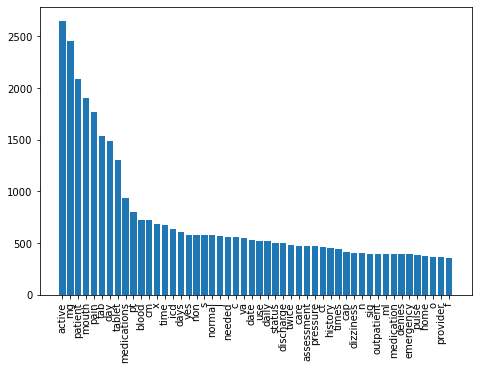

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
words = np.asarray(vectorizer.get_feature_names())[np.argsort(np.sum(X.toarray(), axis=0))[-50:]][::-1]
counts = np.sum(X.toarray(), axis=0)[np.argsort(np.sum(X.toarray(), axis=0))[-50:][::-1]]
ax.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

In [47]:
test_aucs = []
train_aucs = []
test_reports = []
train_reports = []
for i in range(100):
    eX_train, eX_test, ey_train, ey_test = train_test_split(retaineddf.drop("mod_label", axis=1), \
                                                            retaineddf["mod_label"], \
                                                            test_size=0.8, random_state=42)
    model = LogisticRegression(solver='liblinear', penalty='l2', C=0.55, max_iter=1000, fit_intercept = True)
    etest = eX_test.iloc[:,:]
    etrain = eX_train.iloc[:,:]
    model.fit(etrain, ey_train)
    test_probas  = model.predict_proba(etest)
    test_preds = model.predict(etest)
    train_preds = model.predict(etrain)
    train_probas = model.predict_proba(etrain)
    testauc = roc_auc_score(ey_test, test_probas[:,1])
    trainauc = roc_auc_score(ey_train, train_probas[:,1])
    test_aucs += [testauc]
    train_aucs += [trainauc]
    test_reports += [classification_report(ey_test, test_preds, output_dict=True)]
    train_reports += [classification_report(ey_train, train_preds, output_dict=True)]

print(f" Average Test AUC \u00B1 \u03C3 (100 iterations): " +\
      f"{np.average(test_aucs):0.3f} \u00B1 {np.std(test_aucs):0.3f}")
print(f"Average Train AUC \u00B1 \u03C3 (100 iterations): " +\
      f"{np.average(train_aucs):0.3f} \u00B1 {np.std(train_aucs):0.3f}")

 Average Test AUC ± σ (100 iterations): 0.624 ± 0.000
Average Train AUC ± σ (100 iterations): 0.795 ± 0.000


In [49]:
test_aucs = []
train_aucs = []
test_reports = []
train_reports = []
for i in range(100):
    eX_train, eX_test, ey_train, ey_test = train_test_split(pd.concat([retaineddf.reset_index().drop("mod_label", axis=1), pd.DataFrame(X.toarray())], axis=1), \
                                                            retaineddf["mod_label"], \
                                                            test_size=0.8, random_state=42)
    model = LogisticRegression(solver='liblinear', penalty='l1', C=10, max_iter=1000, fit_intercept = False)
    etest = eX_test.iloc[:,:]
    etrain = eX_train.iloc[:,:]
    model.fit(etrain, ey_train)
    test_probas  = model.predict_proba(etest)
    test_preds = model.predict(etest)
    train_preds = model.predict(etrain)
    train_probas = model.predict_proba(etrain)
    testauc = roc_auc_score(ey_test, test_probas[:,1])
    trainauc = roc_auc_score(ey_train, train_probas[:,1])
    test_aucs += [testauc]
    train_aucs += [trainauc]
    test_reports += [classification_report(ey_test, test_preds, output_dict=True)]
    train_reports += [classification_report(ey_train, train_preds, output_dict=True)]

print(f" Average Test AUC \u00B1 \u03C3 (100 iterations): " +\
      f"{np.average(test_aucs):0.3f} \u00B1 {np.std(test_aucs):0.3f}")
print(f"Average Train AUC \u00B1 \u03C3 (100 iterations): " +\
      f"{np.average(train_aucs):0.3f} \u00B1 {np.std(train_aucs):0.3f}")

 Average Test AUC ± σ (100 iterations): 0.440 ± 0.001
Average Train AUC ± σ (100 iterations): 1.000 ± 0.000


In [50]:
vectorizer = CountVectorizer(max_features=3000, tokenizer = custom_tokenizer, stop_words='english', min_df = 10, binary=True)
X = vectorizer.fit_transform(retained_notes.TEXT.values)

In [53]:
test_aucs = []
train_aucs = []
test_reports = []
train_reports = []
for i in range(100):
    eX_train, eX_test, ey_train, ey_test = train_test_split(pd.concat([retaineddf.reset_index().drop("mod_label", axis=1), pd.DataFrame(X.toarray())], axis=1), \
                                                            retaineddf["mod_label"], \
                                                            test_size=0.8, random_state=42)
    model = LogisticRegression(solver='liblinear', penalty='l1', C=1, max_iter=1000, fit_intercept = False)
    etest = eX_test.iloc[:,:]
    etrain = eX_train.iloc[:,:]
    model.fit(etrain, ey_train)
    test_probas  = model.predict_proba(etest)
    test_preds = model.predict(etest)
    train_preds = model.predict(etrain)
    train_probas = model.predict_proba(etrain)
    testauc = roc_auc_score(ey_test, test_probas[:,1])
    trainauc = roc_auc_score(ey_train, train_probas[:,1])
    test_aucs += [testauc]
    train_aucs += [trainauc]
    test_reports += [classification_report(ey_test, test_preds, output_dict=True)]
    train_reports += [classification_report(ey_train, train_preds, output_dict=True)]

print(f" Average Test AUC \u00B1 \u03C3 (100 iterations): " +\
      f"{np.average(test_aucs):0.3f} \u00B1 {np.std(test_aucs):0.3f}")
print(f"Average Train AUC \u00B1 \u03C3 (100 iterations): " +\
      f"{np.average(train_aucs):0.3f} \u00B1 {np.std(train_aucs):0.3f}")

 Average Test AUC ± σ (100 iterations): 0.472 ± 0.000
Average Train AUC ± σ (100 iterations): 1.000 ± 0.000
